In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Key

In [2]:
%%capture --no-stderr
!pip install langchain langchain-community langchain-ollama langchain-openai langchain_chroma pypdf sentence_transformers shutil openpyxl FlagEmbedding

LangGraph可视化依赖

In [ ]:
!sudo apt install -y graphviz libgraphviz-dev
!pip install pygraphviz

In [4]:
import os
import pandas as pd

expr_version = 'new_arch_v3_r1_reasoning_rag'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 加载文档

In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 切分

In [6]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [7]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [8]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings


model_path = '/DataScience/HuggingFace/Models/BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

device: cuda


# 构建流程

In [9]:
# from langchain_deepseek import ChatDeepSeek
from langchain_ollama import ChatOllama

r1 = ChatOllama(model='deepseek-r1:latest', temperature=0.01)
llm = ChatOllama(model='qwen2:7b-instruct')

In [10]:
# resp = r1.invoke('为什么天空是蓝色的')
# resp.content结构为：
# <think>...</think>...

In [11]:
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

In [12]:
class RAGState(TypedDict):
    question: str
    retrieved_context: str
    router_decision: str
    answer_to_question: str
    missing_information: str
    useful_information: str
    reasoning: str
    n_round: int

In [13]:
from langchain_core.prompts import PromptTemplate

VALIDATE_PROMPT = PromptTemplate(
    input_variables=["retrieved_context", "question"],
    template="""
# 任务描述

您是一名检索验证员。
系统会向您提供一个问题和一些背景信息，这些背景信息可能包含问题的答案，也可能不包含。
您的任务是仔细查看这些文本块，并提供包含三个字段的 JSON 响应：

1. status：检索到的背景信息是否包含问题的答案。
- 如果检索到的背景信息包含问题答案，则为 "COMPLETE"，否则为 "INCOMPLETE"。只有这两个取值，其他取值都是非法的。

2. useful_information：从检索到的背景信息中获取的有用信息。要简洁明了。
- 大部分情况下，这部分信息不能为空，如果确实没有有用信息，则将其设置为空字符串。
- 如果status是COMPLETE，则这部分一定要有。

3. missing_information：如果要完整回答这个问题，还需要的信息，这个信息将用来使用向量模型进一步检索知识库，以便补充信息。
- 如果status是INCOMPLETE，则这部分信息一定要有。

# 背景信息

---
{retrieved_context}
---

# 返回值要求
    
    请按以下格式以字典形式提供您的答复。请严格按照此格式返回结果，不要包含描述性内容和任何其他无关内容。

```json
{{"status": "<status>",
"useful_information": "<useful_information>",
"missing_information": "<missing_information>"}}
```
    
这里是响应的样例：

```json
{{"status": "COMPLETE",
"useful_information": "The capital city of Canada is Ottawa.",
"missing_information": "The capital city of Mexico"}}
```


# 问题

{question}
    """
)

ANSWER_QUESTION = PromptTemplate(
    input_variables=["retrieved_context", "question"],
    template="""
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{retrieved_context}
<<<</context>>>

问题：{question}
请回答：
    """
)

## 构建Workflow

In [14]:
import json

In [15]:
n_chunks = 3

In [16]:
import re

def extract_json(text):
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            print("提取的内容不是有效的JSON")
    return None

In [17]:
def retrieve(state: RAGState):
    print(f"\n=== STEP 1: RETRIEVAL (round: {state.get('n_round', 0)})===")
    
    question = state['question']
    print("Searching for:", question)
    
    chunks = vector_db.similarity_search(question, k=n_chunks)
    return {'retrieved_context': '\n\n'.join([doc.page_content for doc in chunks]), 'n_round': state.get('n_round', 0) + 1}

In [18]:
def validate_retrieval(state: RAGState):
    print(f"\n=== STEP 2: VALIDATION (round: {state.get('n_round', 0)})===")
    question = state['question']
    retrieved_context = state['retrieved_context']
    # print("Retrieved Context:\n", retrieved_context)
    
    validation_chain = VALIDATE_PROMPT | r1
    retry_count = 5

    # 兜底
    router_decision = 'INCOMPLETE'
    missing_information = question
    useful_information = ''
    reasoning = ''
    
    while retry_count >= 0:
        try:
            llm_output = validation_chain.invoke({'retrieved_context': retrieved_context, 'question': question}).content
            # print('llm_output:', llm_output)
            
            reasoning = llm_output.split('<think>')[1].split('</think>')[0].strip()
            response = llm_output.split('</think>')[1].strip()
            structured_response = extract_json(response)
        
            router_decision = structured_response['status'].strip().upper()
            missing_information = structured_response['missing_information']
            useful_information = structured_response['useful_information']
            
            print('structured response:', structured_response)
            # print('reasoning:', reasoning)
            print("router decision:", router_decision)
            # print("missing information:", missing_information)
            # print('useful information:', useful_information)
            
            break
        except Exception as e:
            retry_count -= 1
            print(f"error, e: {e}, llm_output: {llm_output}, {retry_count} retries left")

    return {
        'router_decision': router_decision,
        'missing_information': missing_information,
        'useful_information': useful_information,
        'reasoning': reasoning
    }

In [19]:
def answer(state: RAGState):
    print(f"\n=== STEP 3: ANSWERING (round: {state.get('n_round', 0)})===")

    question = state['question']
    context = state['retrieved_context']

    answer_chain = ANSWER_QUESTION | llm
    llm_output = answer_chain.invoke({
        'retrieved_context': context,
        'question': question
    }).content
    # answer = llm_output.split('</think>')[1].strip()
    answer = llm_output.strip()
    print('answer:', answer)
    
    return {'answer_to_question': answer}

In [20]:
def find_missing_information(state: RAGState):
    print(f"\n=== STEP 2b: FINDING MISSING INFORMATION (round: {state.get('n_round', 0)})===")
    question = state["missing_information"]

    print("Searching for:", question)
    
    chunks = vector_db.similarity_search(question, k=n_chunks)
    newly_retrieved_context = '\n\n'.join([doc.page_content for doc in chunks])
    previously_retrieved_useful_information = state["useful_information"]
    
    combined_context = f"{previously_retrieved_useful_information}\n{newly_retrieved_context}"
    # print("newly retrieved context:", newly_retrieved_context)
    
    return {"retrieved_context": combined_context, 'n_round': state.get('n_round', 0) + 1}

In [21]:
def decide_route(state: RAGState):
    return state["router_decision"]

In [22]:
workflow = StateGraph(RAGState)

workflow.add_node('retrieve context', retrieve)
workflow.add_node('is retrieved context complete?', validate_retrieval)
workflow.add_node('answer', answer)
workflow.add_node('find missing information', find_missing_information)

workflow.set_entry_point('retrieve context')
workflow.add_edge('retrieve context', 'is retrieved context complete?')
workflow.add_conditional_edges(
    'is retrieved context complete?',
    decide_route,
    {
        'COMPLETE': 'answer',
        'INCOMPLETE': 'find missing information'
    }
)
workflow.add_edge('find missing information', 'is retrieved context complete?')
workflow.add_edge('answer', END)

In [23]:
compiled_graph = workflow.compile()

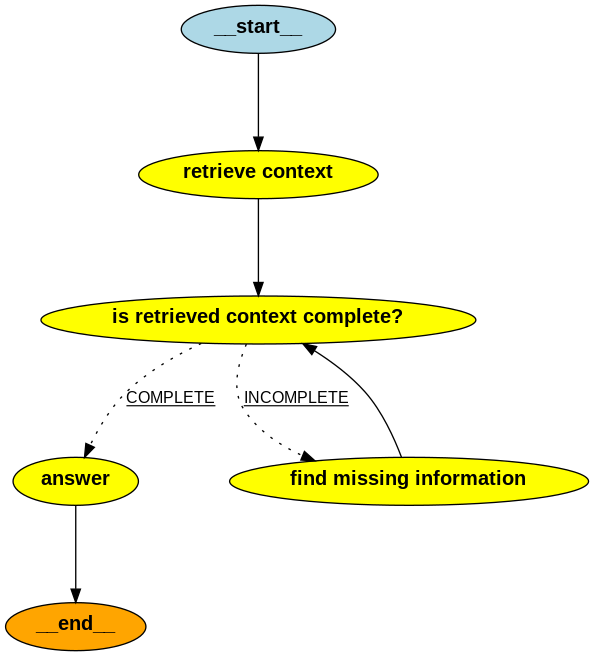

In [55]:
from IPython.display import Image, display

# display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))
draw_graph = compiled_graph.get_graph(xray=True)
display(Image(draw_graph.draw_png()))

In [26]:
qa_df.sample(3)

,uuid,question,answer,context,doc,qa_type,score,score_reason,dataset
380,f6b906f5-212c-49d2-b66d-3b59678358b6,中国与海湾国家合作的四个主要方向是什么？,中国与海湾国家希望成为“共促团结的伙伴”、“共谋发展的伙伴”、“共筑安全的伙伴”和“共兴文明...,NaN,二、三位。\n（三）未来中海合作将跨入新阶段\n第一，政策沟通为中海双方深化合作提供契机和基...,large_context,5,问题询问的是具体的合作方向，答案直接给出了明确的四个方面，没有简单地引用原文，而是进行了总结。,train
3,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,全球贸易增长情况如何？,全球贸易增长乏力。,全球贸易增长乏力，各国生产景气度逐渐回落，内需对经济的拉动作用减弱。,研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12...,detailed,5,问题询问的是全球贸易的实时情况，答案直接给出了评估性的回答，符合要求。,test
77,0943b71a-7314-4cef-a7d9-682c7ddc9d7f,2023年10月美国的失业率是多少？,3.9%,10月失业率提高至3.9%,全球经济金融展望报告\n中国银行研究院 10 2024年\n模下降2.5%，进口降幅大于出口...,detailed,5,问题询问的是具体的数据，需要实时信息更新，符合优质问题的标准。答案直接给出了数值，无需查找原...,train


In [27]:
# result = compiled_graph.invoke({'question': '全球贸易增长情况如何？'})

In [28]:
# result['answer_to_question']

# 批量预测

In [35]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [36]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

In [37]:
# prediction_df = baseline_pred_df[baseline_pred_df['score'] == 0]

In [38]:
prediction_df.shape

(100, 4)

In [39]:
prediction_df.sample(5)

,uuid,question,qa_type,ref_answer
377,61c25726-912a-4bd4-981c-01e9cfa81951,面对经济增长放缓和全球经济挑战，海湾国家采取了什么措施？,large_context,为了应对经济增长放缓和全球经济挑战，沙特、阿联酋等国政府大力推动绿色经济转型和经济多元化改革...
228,dc18ddce-a123-45b5-86e2-2ff1378fb6aa,图20的涨跌幅区间是什么时候？,detailed,2023年1月1日至2023年11月15日
45,2e253555-a34a-48cb-824b-da74f33a9111,图5展示的是哪个部门的债务率？,detailed,部分发达国家非金融企业部门债务率
136,3c0da094-8444-428b-9729-f1caa33e4b06,2023年二季度沙特GDP的同比增长率是多少？,detailed,1.2%
291,8bd98bdb-bbf3-443f-a671-3c13416500f4,在《巴黎协定》生效后，中海合作的新能源领域有哪些?,detailed,光伏、风能、绿氢


In [40]:
if 'finished_questions' in locals():
    finished_questions = locals()['finished_questions']
else:
    finished_questions = set()
    answer_dict = {}

len(finished_questions), len(answer_dict)

(0, 0)

In [41]:
import time

def rag(llm, query, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt).content.strip()
            if resp.startswith('<think>'):
                resp = resp.split('</think>')[1]
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

In [42]:
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row['uuid']
    question = row['question']
    if question in finished_questions:
        continue

    fallback = 0
    compiled_graph = workflow.compile()
    try:
        result = compiled_graph.invoke({'question': question})
        answer = result['answer_to_question']
    except Exception as e:
        print(f"e: {e}, 兜底")
        fallback = 1
        answer, _ = rag(llm, question)
    
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['ref_answer'],
        'gen_answer': answer,
        'fallback': fallback
    }
    finished_questions.add(question)

  0%|          | 0/100 [00:00<?, ?it/s]


=== STEP 1: RETRIEVAL (round: 0)===
Searching for: 报告的发布机构是什么？

=== STEP 2: VALIDATION (round: 1)===
structured response: {'status': 'COMPLETE', 'useful_information': '报告的发布机构是中国银行研究院', 'missing_information': ''}
router decision: COMPLETE

=== STEP 3: ANSWERING (round: 1)===
answer: 报告的发布机构是中国银行研究院。

=== STEP 1: RETRIEVAL (round: 0)===
Searching for: 报告的发布日期是什么时候？

=== STEP 2: VALIDATION (round: 1)===
structured response: {'status': 'INCOMPLETE', 'useful_information': '2024年发布的报告', 'missing_information': '报告的发布月份和日期'}
router decision: INCOMPLETE

=== STEP 2b: FINDING MISSING INFORMATION (round: 1)===
Searching for: 报告的发布月份和日期

=== STEP 2: VALIDATION (round: 2)===
structured response: {'status': 'INCOMPLETE', 'useful_information': '报告发布于2024年，是中国银行研究院的32期。', 'missing_information': '报告的具体发布月份和日期；报告的详细内容或背景信息。'}
router decision: INCOMPLETE

=== STEP 2b: FINDING MISSING INFORMATION (round: 2)===
Searching for: 报告的具体发布月份和日期；报告的详细内容或背景信息。

=== STEP 2: VALIDATION (round: 3)===
structured res

In [43]:
prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'fallback'] = prediction_df['question'].apply(lambda q: answer_dict[q]['fallback'])

In [44]:
prediction_df['fallback'].sum()

4

# 评估

In [45]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [46]:
prediction_df['raw_score'] = evaluate(prediction_df)

In [47]:
prediction_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [48]:
prediction_df['score'] = (prediction_df['raw_score'] == '是').astype(int)

In [49]:
prediction_df['score'].mean()

0.67

In [50]:
prediction_df['score'].sum()

67

In [52]:
prediction_df['fallback'].sum()

4

有4条发生兜底

<Axes: xlabel='fallback', ylabel='score'>

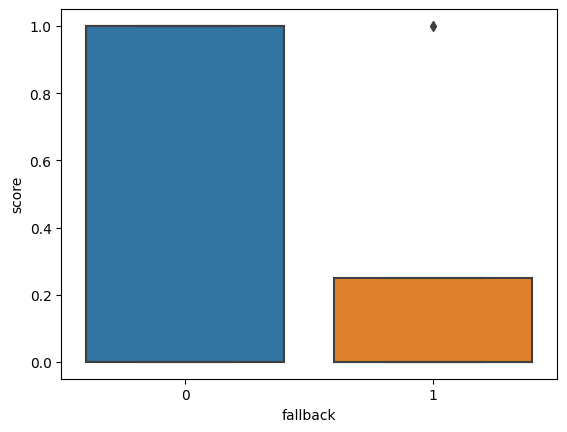

In [53]:
import seaborn as sns

sns.boxplot(x='fallback', y='score', data=prediction_df)